In [2]:
!pip install nltk
!pip install emoji
!pip install seaborn
!pip install imbalanced-learn
!pip install xgboost
!pip install lightgbm
!pip install wordcloud
import pandas as pd
import numpy as np
import re
import string
import nltk
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
# Import word_tokenize
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter
from wordcloud import WordCloud
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt_tab')
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
# Download punkt for word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /home/maruf/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/maruf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/maruf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/maruf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv("YoutubeCommentsDataSet.csv")

print("Initial shape:", df.shape)
print("Sentiment distribution:\n", df['Sentiment'].value_counts())
df.dropna(subset=['Comment'], inplace=True)


Initial shape: (18408, 2)
Sentiment distribution:
 Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64


In [4]:


stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are",
    "'s": " is", "'d": " would", "'ll": " will", "'t": " not", "'ve": " have", "'m": " am"
}

def clean_text(text):
    text = str(text).lower()
    for c, e in contractions.items():
        text = re.sub(c, e, text)
    text = emoji.replace_emoji(text, replace='')  # Remove emojis
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetic characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [t for t in tokens if t not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  # Lemmatization instead of stemming for better readability
    return " ".join(tokens)

# Apply the cleaning function
df['Cleaned_Comment'] = df['Comment'].apply(clean_text)

# Show original vs. cleaned comments
pd.set_option('display.max_colwidth', None)
df[['Comment', 'Cleaned_Comment']].head(10)

,Comment,Cleaned_Comment
0,lets not forget that apple pay in 2014 required a brand new iphone in order to use it a significant portion of apples user base wasnt able to use it even if they wanted to as each successive iphone incorporated the technology and older iphones were replaced the number of people who could use the technology increased,let forget apple pay required brand new iphone order use significant portion apple user base wasnt able use even wanted successive iphone incorporated technology older iphones replaced number people could use technology increased
1,here in nz 50 of retailers don’t even have contactless credit card machines like paywave which support apple pay they don’t like the high fees that come with these,nz retailer dont even contactless credit card machine like paywave support apple pay dont like high fee come
2,i will forever acknowledge this channel with the help of your lessons and ideas explanations now its quite helpful while youll just sit at your comfort and monitor your account growth,forever acknowledge channel help lesson idea explanation quite helpful youll sit comfort monitor account growth
3,whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my shopping routine i’ve officially been brainwashed by apple because now it feels so inconvenient to even carry a physical card in my pocket,whenever go place doesnt take apple pay doesnt happen often drag contactless covid habit getting apple card ive gotten used apple pay get seriously annoyed store doesnt take feel like shock crazy quickly took shopping routine ive officially brainwashed apple feel inconvenient even carry physical card pocket
4,apple pay is so convenient secure and easy to use i used it while at the korean and japanese airports no need for physical credit cards,apple pay convenient secure easy use used korean japanese airport need physical credit card
5,we’ve been hounding my bank to adopt apple pay i understand why they don’t want to do it with the extra fees but its just so easy and quick at the checkout,weve hounding bank adopt apple pay understand dont want extra fee easy quick checkout
6,we only got apple pay in south africa in 20202021 and it’s widely accepted,got apple pay south africa widely accepted
7,for now i need both apple pay and the physical credit card,need apple pay physical credit card
8,in the united states we have an abundance of retailers that accept apple pay but its still good to carry the physical card with you being there are still a large quantity of places that do not accept apple pay,united state abundance retailer accept apple pay still good carry physical card still large quantity place accept apple pay
9,in cambodia we have a universal qr code system we scan and send money back and forth all banks take no profit from merchant they receive 100 of the payment a lot of stores and supermarkets start abandon pos machine all together,cambodia universal qr code system scan send money back forth bank take profit merchant receive payment lot store supermarket start abandon po machine together


In [5]:
df['Cleaned'] = df['Comment'].apply(clean_text)
df['Length'] = df['Cleaned'].apply(lambda x: len(x.split()))
df = df[df['Length'] >= 3]
df.drop_duplicates(subset='Cleaned', inplace=True)


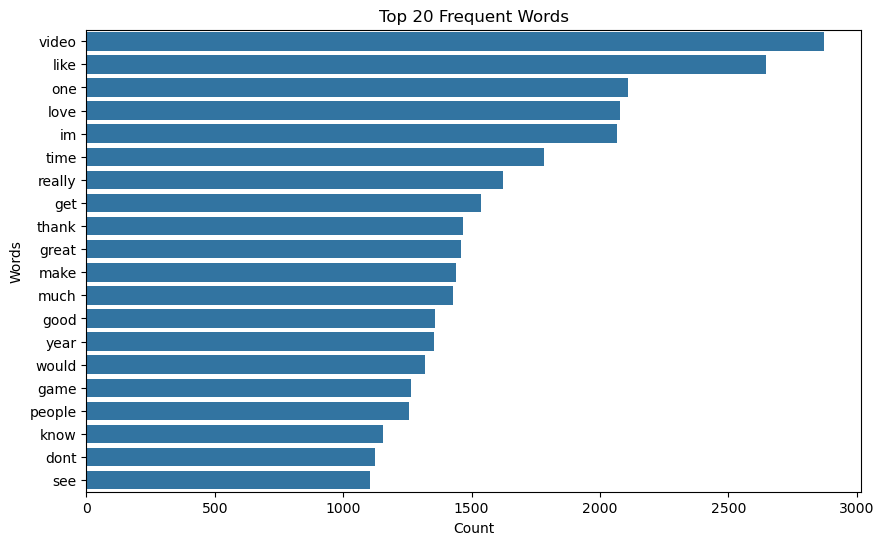

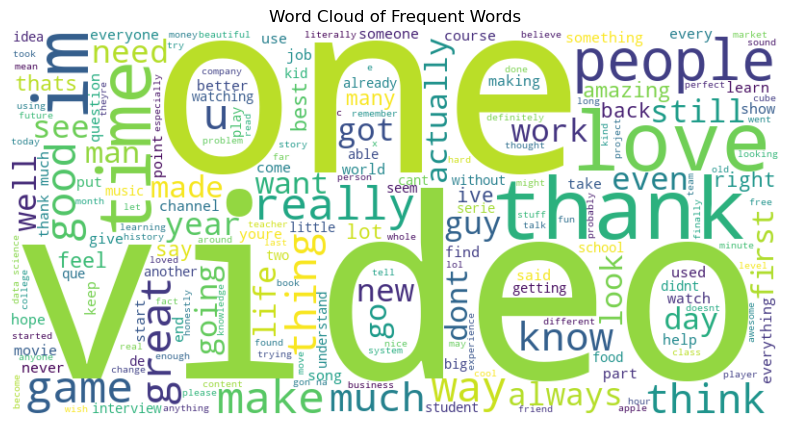

In [6]:
# Flatten the tokens
all_words = ' '.join(df['Cleaned_Comment'])  # Use the correct column name here
word_freq = Counter(all_words.split())

# Plot top 20 words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Frequent Words')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

# Optionally add WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Words')
plt.show()


In [7]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Sentiment'])

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['Cleaned'])
y = df['Label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=150),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel="linear", probability=True),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier()
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:25:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


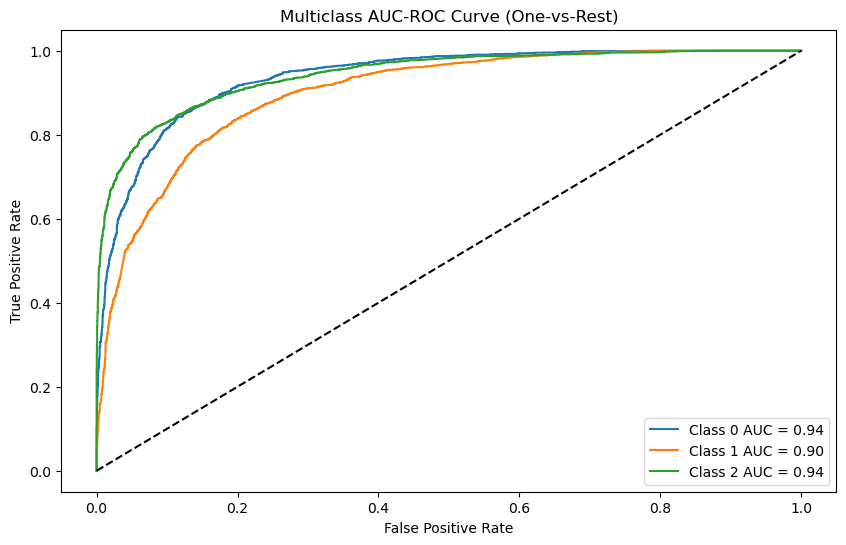

In [9]:


# Get predicted probabilities for all classes
y_pred_proba = model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

n_classes = y_pred_proba.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])  # One-vs-rest
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass AUC-ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.429301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.361264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122861
[LightGBM] [Info] Number of data points in the train set: 25483, number of used features: 4221
[LightGBM] [Info] Start training from score -1.098534
[LightGBM] [Info] Start training from score -1.098652
[LightGBM] [Info] Start training from score -1.098652


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


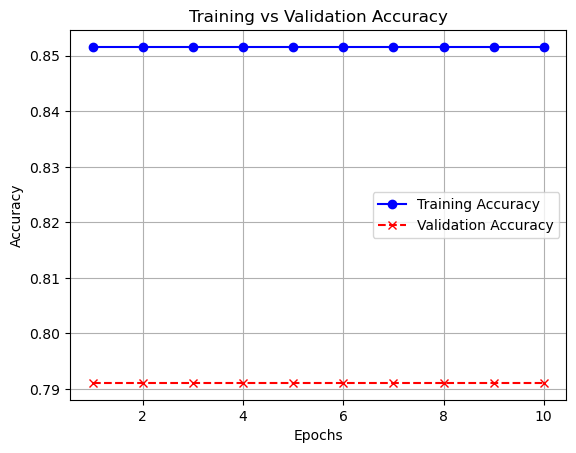

In [10]:
# Define the number of epochs (you can set this based on your model requirements)
epochs = 10

train_accuracy = []  # To store training accuracy for each epoch
val_accuracy = []    # To store validation accuracy for each epoch

# Assuming you have a model and data for training
for epoch in range(epochs):  # epochs is the number of training iterations
    # Train the model (scikit-learn models use fit instead of train)
    model.fit(X_train, y_train)  # Train the model on the training data
    
    # Calculate training accuracy for the epoch
    train_pred = model.predict(X_train)
    train_acc = (train_pred == y_train).mean()
    train_accuracy.append(train_acc)

    # Validate the model
    val_pred = model.predict(X_test)  # Predict on validation data
    val_acc = (val_pred == y_test).mean()
    val_accuracy.append(val_acc)

# Once you have the accuracies in train_accuracy and val_accuracy
epochs_range = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', marker='x', linestyle='--', color='r')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()



🔹 Model: Logistic Regression
Accuracy: 81.05 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.83      0.82      2123
     neutral       0.75      0.81      0.78      2124
    positive       0.89      0.79      0.84      2124

    accuracy                           0.81      6371
   macro avg       0.82      0.81      0.81      6371
weighted avg       0.82      0.81      0.81      6371



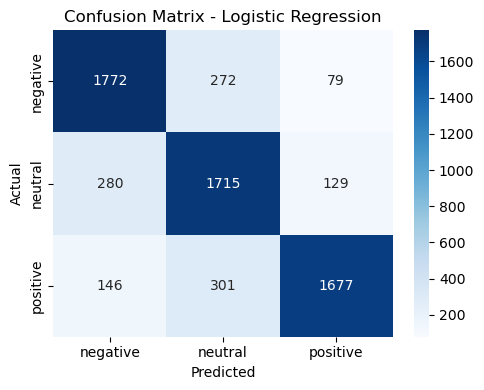


🔹 Model: Random Forest
Accuracy: 88.01 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.93      0.90      2123
     neutral       0.86      0.86      0.86      2124
    positive       0.90      0.85      0.87      2124

    accuracy                           0.88      6371
   macro avg       0.88      0.88      0.88      6371
weighted avg       0.88      0.88      0.88      6371



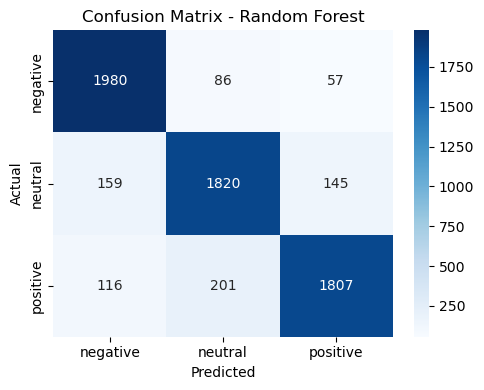


🔹 Model: Decision Tree
Accuracy: 79.16 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.85      0.83      2123
     neutral       0.76      0.78      0.77      2124
    positive       0.81      0.75      0.78      2124

    accuracy                           0.79      6371
   macro avg       0.79      0.79      0.79      6371
weighted avg       0.79      0.79      0.79      6371



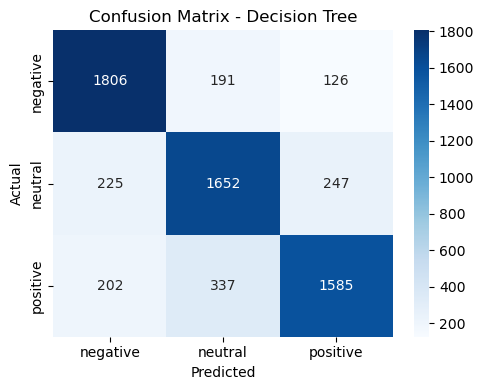


🔹 Model: Naive Bayes
Accuracy: 75.18 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.92      0.79      2123
     neutral       0.84      0.53      0.65      2124
    positive       0.76      0.81      0.79      2124

    accuracy                           0.75      6371
   macro avg       0.77      0.75      0.74      6371
weighted avg       0.77      0.75      0.74      6371



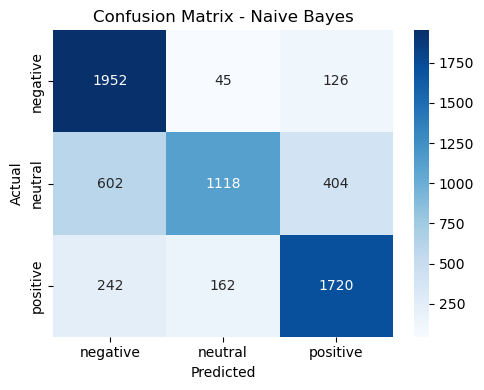


🔹 Model: SVM
Accuracy: 81.89 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.83      0.83      2123
     neutral       0.74      0.84      0.79      2124
    positive       0.91      0.79      0.84      2124

    accuracy                           0.82      6371
   macro avg       0.83      0.82      0.82      6371
weighted avg       0.83      0.82      0.82      6371



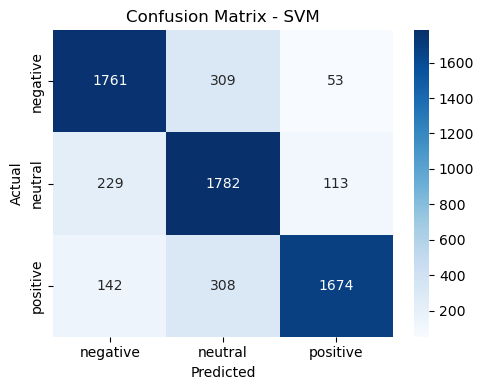


🔹 Model: XGBoost
Accuracy: 77.55 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.76      0.78      2123
     neutral       0.69      0.81      0.74      2124
    positive       0.86      0.76      0.81      2124

    accuracy                           0.78      6371
   macro avg       0.78      0.78      0.78      6371
weighted avg       0.78      0.78      0.78      6371



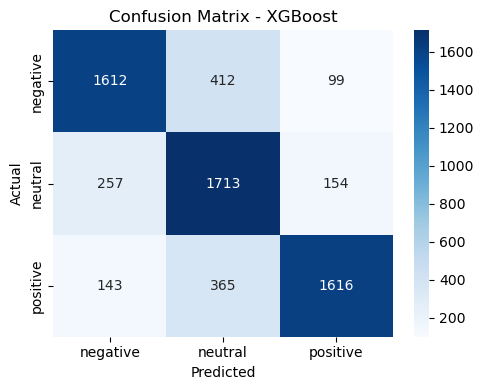


🔹 Model: LightGBM
Accuracy: 79.11 %
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.80      0.80      2123
     neutral       0.73      0.78      0.75      2124
    positive       0.85      0.79      0.82      2124

    accuracy                           0.79      6371
   macro avg       0.79      0.79      0.79      6371
weighted avg       0.79      0.79      0.79      6371



/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


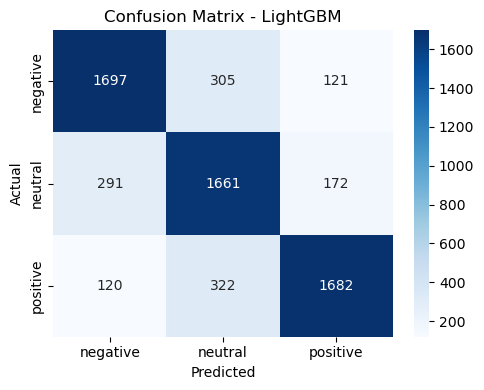

In [11]:
for name, model in trained_models.items():
    print(f"\n🔹 Model: {name}")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(acc * 100, 2), "%")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


Index(['Comment', 'Sentiment', 'Cleaned_Comment', 'Cleaned', 'Length',
       'Label'],
      dtype='object')


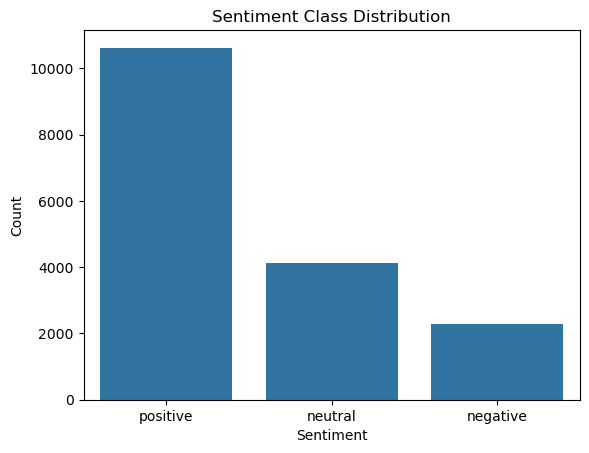

In [12]:
# Sentiment Curve Example with sentiment labels like 'positive', 'negative', 'neutral'

# Verify the actual column name by checking the DataFrame columns
print(df.columns)

# Replace 'sentiment' with the correct column name, for example 'Sentiment'
sentiment_counts = df['Sentiment'].value_counts()

# Plot sentiment distribution
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


/home/maruf/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_15106/2114445547.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="coolwarm")


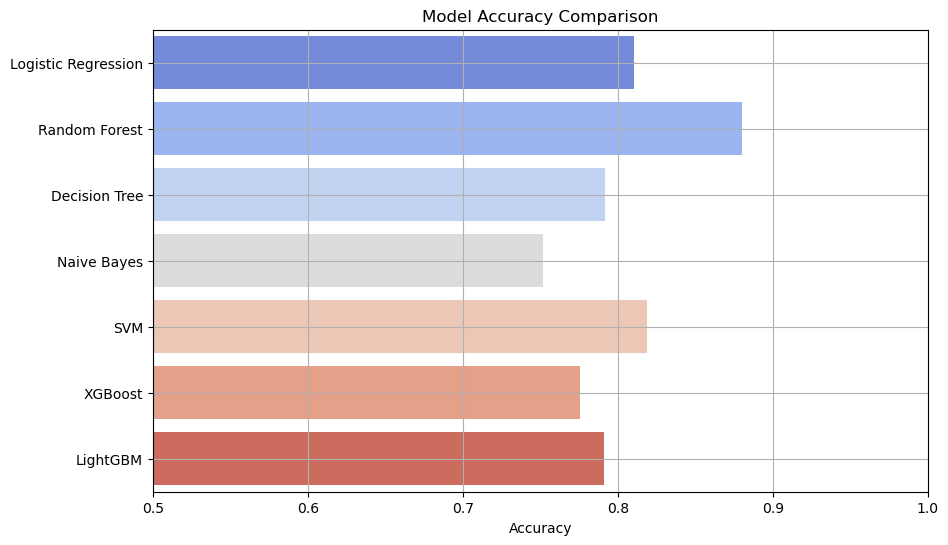

In [13]:
model_names = list(trained_models.keys())
accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in trained_models.values()]

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette="coolwarm")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.xlim(0.5, 1.0)
plt.grid(True)
plt.show()
